### Implementing simple Chatbot Using LangGraph

In [53]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [54]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [55]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [56]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BY6SVP2Jd2XsZ0uHB8sFSesLHmynD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0f5c6404-3eca-4584-ad75-486eafc638bf-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [57]:
from langchain_groq import ChatGroq

llm_groq = ChatGroq(model="qwen-qwq-32b")
llm_groq.invoke("Hey I am Mohan and i like to play cricket")

AIMessage(content="\n<think>\nOkay, the user introduced himself as Mohan and mentioned he likes to play cricket. I should respond warmly. Let me start by greeting him back. Maybe ask him how he's doing today to keep the conversation going. Since he mentioned cricket, I can express my own interest in the sport and maybe ask about his favorite team or player. That should encourage him to share more. I should keep it friendly and open-ended so he feels comfortable. Let me check for any typos and make sure the tone is positive. Alright, that should work.\n\nWait, maybe I should also mention a recent cricket event or a popular team to make it relatable. But since I don't have real-time data, I'll stick to general topics. Yeah, asking about his favorite team or player is good. Let me put that together in a natural way. Make sure it's not too long and sounds genuine. Okay, that should be a nice start to the conversation.\n</think>\n\nHey Mohan! Nice to meet you! 😊 How are you today? I love cr

### We Will start With Creating Nodes

In [58]:
from langgraph.checkpoint.memory import MemorySaver 
memory = MemorySaver()

def superbot(state:State):
    return {"messages":[llm_groq.invoke(state['messages'])]}

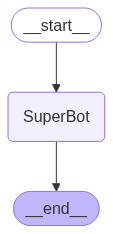

In [59]:
graph =  StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder = graph.compile(checkpointer = memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [60]:
## Invocation

##Specify the thread
config = {"configurable":{"thread_id":"1"}}

#we are using memeory saver , so we needed to give the config cumpolsory
graph_builder.invoke({'messages':"Hi,My name is Mohan And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Mohan And I like cricket', additional_kwargs={}, response_metadata={}, id='c6732456-a2cc-4536-b56b-3a4157bfa528'),
  AIMessage(content="\n<think>\nOkay, the user introduced themselves as Mohan and mentioned they like cricket. I should respond warmly. Let me start with a greeting and acknowledge their name and interest. Maybe ask a follow-up question about cricket to keep the conversation going. I can ask if they have a favorite team or player. Also, make sure the tone is friendly and open. Let me check for any typos and keep the response concise.\n\nWait, the user might be from a country where cricket is popular, like India. Maybe mention a popular team there, such as the Indian cricket team. But don't assume, just keep it general. Make sure the question is inviting so they feel comfortable sharing more. Alright, that should work.\n</think>\n\nHi Mohan! Nice to meet you. 😊 Cricket is a fantastic sport—I hope you're having a great time f

### Streaming the responses with streanm Method

In [61]:
# Create a thread 
config = {"configurable":{"thread_id":"2"}}


### about the chunk
for chunk in graph_builder.stream({'messages':"Hi,My name is Mohan and I like Cricket"},config, stream_mode="updates"):
    print(chunk)


{'SuperBot': {'messages': [AIMessage(content='\n<think>\nOkay, the user introduced themselves as Mohan and mentioned they like cricket. I should respond in a friendly and engaging way. Let me start by greeting them back. Maybe say "Hi Mohan!" to make it personal.\n\nNext, I need to acknowledge their interest in cricket. I can express enthusiasm about that. Perhaps something like, "Great to meet you! I love cricket too!" That shows we share a common interest, which is good for building rapport.\n\nThen, I should ask a question to keep the conversation going. Maybe ask about their favorite team or player. "Which team or player do you support?" That\'s open-ended and invites them to share more details. Alternatively, I could mention a recent event in cricket, like the T20 World Cup, to make it timely. But since I don\'t know the current date, maybe it\'s safer to just ask generally.\n\nWait, should I mention specific teams? Maybe not unless I\'m sure. Just asking about their favorite team

In [62]:
### about the chunk
for chunk in graph_builder.stream({'messages':"Hi,My name is Mohan and I like Cricket"},config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Mohan and I like Cricket', additional_kwargs={}, response_metadata={}, id='5410ffc9-888e-4dd6-bf3f-16d79a48f278'), AIMessage(content='\n<think>\nOkay, the user introduced themselves as Mohan and mentioned they like cricket. I should respond in a friendly and engaging way. Let me start by greeting them back. Maybe say "Hi Mohan!" to make it personal.\n\nNext, I need to acknowledge their interest in cricket. I can express enthusiasm about that. Perhaps something like, "Great to meet you! I love cricket too!" That shows we share a common interest, which is good for building rapport.\n\nThen, I should ask a question to keep the conversation going. Maybe ask about their favorite team or player. "Which team or player do you support?" That\'s open-ended and invites them to share more details. Alternatively, I could mention a recent event in cricket, like the T20 World Cup, to make it timely. But since I don\'t know the current date, maybe it\'

In [63]:
### about the chunk
for chunk in graph_builder.stream({'messages':"And also i like to do cycling when i am free"},config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Mohan and I like Cricket', additional_kwargs={}, response_metadata={}, id='5410ffc9-888e-4dd6-bf3f-16d79a48f278'), AIMessage(content='\n<think>\nOkay, the user introduced themselves as Mohan and mentioned they like cricket. I should respond in a friendly and engaging way. Let me start by greeting them back. Maybe say "Hi Mohan!" to make it personal.\n\nNext, I need to acknowledge their interest in cricket. I can express enthusiasm about that. Perhaps something like, "Great to meet you! I love cricket too!" That shows we share a common interest, which is good for building rapport.\n\nThen, I should ask a question to keep the conversation going. Maybe ask about their favorite team or player. "Which team or player do you support?" That\'s open-ended and invites them to share more details. Alternatively, I could mention a recent event in cricket, like the T20 World Cup, to make it timely. But since I don\'t know the current date, maybe it\'

### Streaming The Responses With `astream Method`

**Streaming tokens**  
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the `.astream_events` method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- `event`: This is the type of event that is being emitted.
- `name`: This is the name of event.
- `data`: This is the data associated with the event.
- `metadata`: Contains `langgraph_node`, the node emitting the event.


In [ ]:
config = {"configurable":{"thread_id":"3"}}


async for event in graph_builder.astream_events(
    {"messages":["Hi My name is Mohan and i Like to play Cricket"]},
    config,version='v2'):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Mohan and i Like to play Cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '804be34e-b750-47c2-9c2d-fe15eee6cd69', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and i Like to play Cricket', additional_kwargs={}, response_metadata={}, id='8304b7ce-2636-4251-9d56-3b84d256f430'), AIMessage(content="\n<think>\nOkay, the user introduced themselves as Krish, who likes to play cricket. I should respond in a friendly way. Let me start by greeting them back. Maybe mention cricket to show interest. I can ask about their favorite part of the game or if they have a favorite team or player. That could keep the conversation going. Also, maybe mention some common cricket topics like recent matches or tournaments to see if they're interested. Need to keep it casual and engaging without being too pushy. Let me put that